In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-12-21 07:20:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   200MB/s    in 0.3s    

2024-12-21 07:20:54 (200 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

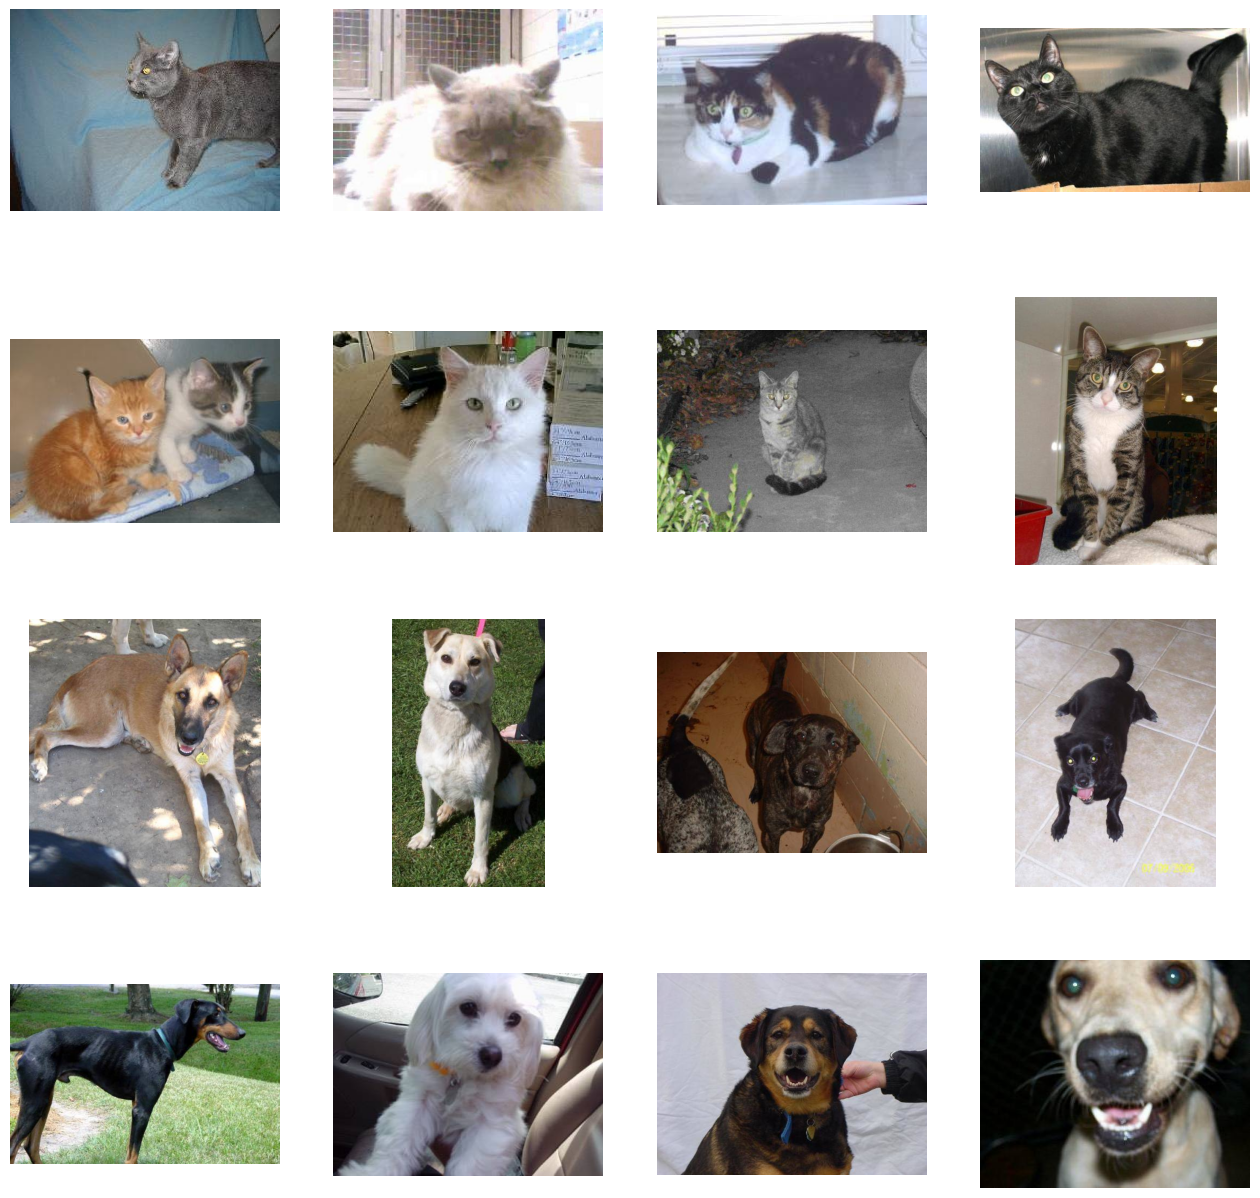

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

#plt.show()

In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.
)

In [9]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(224, 224)
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(224, 224)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(
    input_shape=(224, 224, 3),  # Shape of our images
    include_top=False,  # Leave out the last fully connected layer
    weights='imagenet'
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:

for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

#loss function = binary_crossentropy; also called lorithmic/log loss function
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [13]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - acc: 0.6104 - loss: 0.9407 - val_acc: 0.8780 - val_loss: 0.3088
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8780 - val_loss: 0.3088
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 316ms/step - acc: 0.7658 - loss: 0.4852 - val_acc: 0.8310 - val_loss: 0.3685
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8310 - val_loss: 0.3685
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - acc: 0.8060 - loss: 0.4273 - val_acc: 0.9020 - val_loss: 0.2400
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.9020 - val_loss: 0.2400
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 317ms/step - acc: 0.8236 - loss: 0.3795 - val_acc: 0.9200 - val_loss: 0.2177
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.9200 - val_loss: 0.2177
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 328ms/step - acc: 0.8335 - loss: 0.3439 - val_acc: 0.9240 - val_loss: 0.2042
Epoch 10/10
100/100